In [1]:
import numpy as np
import sys
from pathlib import Path

sys.path.append('../code/')

from mlalgos import BuildNN
from mllib import Utilities,MLUtilities

from time import time
import pickle

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.colors as pltcol
import gc

ut = Utilities()
ml = MLUtilities()

In [2]:
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 14 # 16
mpl.rcParams['legend.fontsize'] = 12 # 14
mpl.rcParams['legend.labelspacing'] = 0.125 # 0.25
FS = 18
FS2 = 14
FS3 = 12
FSL = 22

mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.size'] = 3

#mpl.rcParams.keys()

# Example usage of subconscious learning 

In [3]:
Plot_Stem = 'subconscious/plots'
Path(Plot_Stem).mkdir(parents=True,exist_ok=True)

Save_Fig = True

In [4]:
Shallow = False
Depth_Str_Root = 'shallow' if Shallow else 'deep'

Standardize_X = False # whether or not to standardize features
Standardize_Y = True # whether or not to standardize labels

if Standardize_X:
    if Standardize_Y:
        Depth_Str = Depth_Str_Root + '_stdXstdY'
    else:
        Depth_Str = Depth_Str_Root + '_stdX'
else:
    if Standardize_Y:
        Depth_Str = Depth_Str_Root + '_stdY'
    else:
        Depth_Str = Depth_Str_Root + '_nostd'
print(Depth_Str)

Std_Text = 'std: '
if Standardize_X:
    Std_Text += 'X,Y' if Standardize_Y else 'X'
else:
    Std_Text += 'Y' if Standardize_Y else 'none'

deep_stdY


## Regression example: 1-d Gaussian family

### Function definition

In [5]:
def func_gauss1d(x,params):
    """ Expect x as 1-d array, params as array of shape (0,), (1,) or (2,). """
    mu = params[0] if len(params) > 0 else 0.0
    sig2 = 10**params[1] if len(params) > 1 else 1.0
    return np.exp(-0.5*(x-mu)**2/sig2)/np.sqrt(2*np.pi*sig2)

### Training & testing samples

In [6]:
Ftype = 'gf1d'

ExDict = {'gf1d':{'root':'gf1d_','text':'1-d Gaussian',
                  'func':func_gauss1d,'xbounds':[-2.5,3.0],
                  'pbounds':{'min':[-0.5,-0.2], # minimum mu,lgsig2
                             'max':[ 0.5, 0.2]} # maximum mu,lgsig2
                 }
         }

if Ftype not in ExDict.keys():
    raise Exception("FType must be one of ["+','.join(key for key in list(ExDict.keys()))+']')

Example_Root = ExDict[Ftype]['root'] + Depth_Str
print(Example_Root)

Example_Text = ExDict[Ftype]['text']

example_func = ExDict[Ftype]['func']
xmin,xmax = ExDict[Ftype]['xbounds']
param_mins = ExDict[Ftype]['pbounds']['min'] 
param_maxs = ExDict[Ftype]['pbounds']['max'] 


gf1d_deep_stdY


Generating data for 1-d Gaussian family...
... training sample
... sample of size 2500 created
... testing sample
... sample of size 15000 created
... done
0 min 0.00 seconds



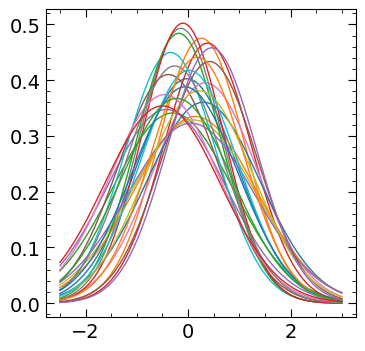

In [7]:
start_time = time()

print('Generating data for '+Example_Text+' family...')

seed = 1983
rng = np.random.RandomState(seed)

#################################################
# Training set
print('... training sample')
n_x_train = 100
xtrain = np.linspace(xmin,xmax,n_x_train)

n_lhc_train = 25 # no. of Latin hypercube samples
n_params = len(param_mins)

# LHC of shape (n_lhc_train,n_params)
if len(param_mins) > 0:
    params_train = ut.gen_latin_hypercube(Nsamp=n_lhc_train,dim=n_params,param_mins=param_mins,param_maxs=param_maxs,rng=rng) 
else:
    params_train = [[]]

n_train = n_lhc_train*n_x_train

X_train = np.zeros((n_train,n_params+1)) # features = {params},x; X will be transposed later
Y_train = np.zeros((1,n_train))

for n in range(n_lhc_train):
    sl = np.s_[n*n_x_train:(n+1)*n_x_train]
    for p in range(n_params):
        X_train[sl,p] = params_train[n,p]
    X_train[sl,-1] = xtrain
    Y_train[0,sl] = example_func(xtrain,params_train[n])

X_train = X_train.T
print('... sample of size {0:d} created'.format(n_train))
#################################################
# Testing set
print('... testing sample')
n_x_test = 200
xtest = (xmax-xmin)*rng.random_sample(n_x_test) + xmin

n_lhc_test = 75 # no. of Latin hypercube samples

# LHC of shape (n_lhc_test,n_params)
if len(param_mins) > 0:
    params_test = ut.gen_latin_hypercube(Nsamp=n_lhc_test,dim=n_params,param_mins=param_mins,param_maxs=param_maxs,rng=rng) 
else:
    params_test = [[]]

n_test = n_lhc_test*n_x_test

X_test = np.zeros((n_test,n_params+1)) # features = {params},x; X will be transposed later
Y_test = np.zeros((1,n_test))

for n in range(n_lhc_test):
    sl = np.s_[n*n_x_test:(n+1)*n_x_test]
    for p in range(n_params):
        X_test[sl,p] = params_test[n,p]
    X_test[sl,-1] = xtest
    Y_test[0,sl] = example_func(xtest,params_test[n])

X_test = X_test.T
print('... sample of size {0:d} created'.format(n_test))
print('... done')
ut.time_this(start_time)

plt.figure(figsize=(4,4))
for n in range(n_lhc_train):
    sl = np.s_[n*n_x_train:(n+1)*n_x_train]
    plt.plot(xtrain,Y_train[0,sl],lw=1)
plt.minorticks_on()
plt.show()

### Network setup and training

In [8]:
Max_Epoch = 1000

#### Non-ensembled, conscious

File_Stem: subconscious/gf1d_deep_stdY
Feed-forward neural network setup...
... found data set of dimension 3 with targets of dimension 1
... found 2500 samples
... fraction 0.800 (2000 samples) will be used for training
... will use residual percentiles for hyperparameter comparison
... setup complete
Loaded network with
...    setup params:  {'data_dim': 3, 'loss_type': 'square', 'adam': True, 'seed': None, 'standardize_X': False, 'standardize_Y': True, 'file_stem': 'subconscious/gf1d_deep_stdY/net', 'verbose': False, 'logfile': None, 'neg_labels': True, 'L': 24, 'wt_decay': 0.0, 'n_layer': [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 1], 'reg_fun': 'none', 'atypes': ['relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'lin'], 'threshold': None, 'Y_std': array([[0.14094444]]), 'Y_mean': array([[0.17762761]]

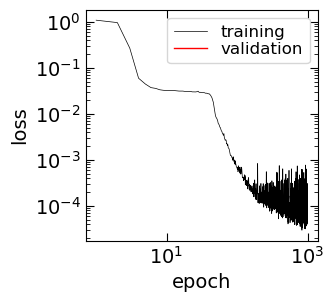

0 min 0.47 seconds



In [9]:
Build = False

Example_Stem_Single = Example_Root

File_Stem = 'subconscious/' + Example_Stem_Single
print('File_Stem:',File_Stem)

Train_Frac = 0.8                               # fraction of input samples to use for training+validation. 
                                               # remaining used for arch and hyperparam comparisons.
Check_After = Max_Epoch                        # epoch after which to activate validation (early stopping) checks
Val_Frac = 0.2 if Check_After < Max_Epoch else 0.0
                                               # fraction of Train_Frac to use for validation, i.e. early stopping criterion.
Arch_Type = 'emulator:'+Depth_Str_Root         # None or one of ['emulator:deep','emulator:shallow','no_reg','autoenc']. 
Min_Layer = 2 if Shallow else 4                # minimum number of layers (x4 for deep)
Max_Layer = 4 if Shallow else 6                # maximum number of layers (x4 for deep)
Max_Ex = [7,17]                                # int or list of ints. number of nodes in excess of input dimension 
                                               # (currently forced to be constant across layers)
HTypes = ['tanh'] if Shallow else ['relu']     # None or subset of ['tanh','relu','lrelu','requ','splus'] 
LRates = [3e-4,1e-3]                           # None or list of floats: learning rates
Wt_Decays = [0.0,0.1]                          # non-empty list of floats: weight decay values
N_Iter = 3                                     # number of iterations for each choice of arch and hyperparams
Loss_Type = 'square'                           # one of ['square','hinge','nll','nllm']
Seed = None                                    # None or int, random number seed.
Test_Type = 'perc'                             # one of 'perc' (residual percentiles) or 'mse' (mean squared error). 
                                               # relevant for regression (square/hinge loss).
Parallel = True                                # train networks in parallel
NProc = 10                                     # number of concurrent processes (only relevant if Parallel = True)
Dream_Schedules = [None]                       # dreaming schedules

start_time = time()
bnn = BuildNN(X_train,Y_train,train_frac=Train_Frac,arch_type=Arch_Type,standardize_X=Standardize_X,standardize_Y=Standardize_Y,
              max_ex=Max_Ex,min_layer=Min_Layer,max_layer=Max_Layer,dream_schedules=Dream_Schedules,
              val_frac=Val_Frac,n_iter=N_Iter,wt_decays=Wt_Decays,lrates=LRates,htypes=HTypes,check_after=Check_After,
              parallel=Parallel,nproc=NProc,loss_type=Loss_Type,test_type=Test_Type,seed=Seed,file_stem=File_Stem,ensemble=False)
if Build:
    net,params_train,bts = bnn.trainNN(max_epoch=Max_Epoch)
    print('Best test stat = {0:.3e}'.format(bts))
    print('Setup params: ',net.params)
    print('Training params: ',params_train)
else:
    net = bnn.load()
    print('Loaded network with')
    print('...    setup params: ',net.params)
    params_train,bts = bnn.load_train()
    print('... best test stat: {0:.3e}'.format(bts))
    print('... training params: ',params_train)

print('No. of free params optimized = {0:d}\n'.format(net.calc_N_freeparams()))

plt.figure(figsize=(3,3))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(net.epochs,net.training_loss,'k-',lw=0.5,label='training')
plt.plot(net.epochs,net.val_loss,'r-',lw=1,label='validation')
plt.legend()
plt.show()

residual = np.squeeze(net.predict(X_test)/(Y_test + 1e-15) - 1)

ut.time_this(start_time)

#### Non-ensembled, subconscious

File_Stem: subconscious/gf1d_deep_stdY_subc
Feed-forward neural network setup...
... found data set of dimension 3 with targets of dimension 1
... found 2500 samples
... fraction 0.800 (2000 samples) will be used for training
... will use residual percentiles for hyperparameter comparison
... setup complete
Loaded network with
...    setup params:  {'data_dim': 3, 'loss_type': 'square', 'adam': True, 'seed': None, 'standardize_X': False, 'standardize_Y': True, 'file_stem': 'subconscious/gf1d_deep_stdY_subc/net', 'verbose': False, 'logfile': None, 'neg_labels': True, 'L': 20, 'wt_decay': 0.0, 'n_layer': [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 1], 'reg_fun': 'none', 'atypes': ['relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'relu', 'lin'], 'threshold': None, 'Y_std': array([[0.14168631]]), 'Y_mean': array([[0.17864362]]), 'X_std': 1.0, 'X_mean': 0.0}
... be

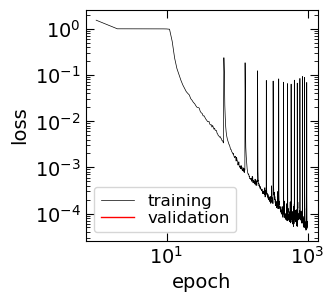

0 min 0.20 seconds



In [10]:
Build = False

Example_Stem_Single = Example_Root + '_subc'

File_Stem = 'subconscious/' + Example_Stem_Single
print('File_Stem:',File_Stem)

Train_Frac = 0.8                               # fraction of input samples to use for training+validation. 
                                               # fraction of input samples to use for training+validation. 
                                               # remaining used for arch and hyperparam comparisons.
Check_After = Max_Epoch                        # epoch after which to activate validation (early stopping) checks
Val_Frac = 0.2 if Check_After < Max_Epoch else 0.0
                                               # fraction of Train_Frac to use for validation, i.e. early stopping criterion.
Arch_Type = 'emulator:'+Depth_Str_Root         # None or one of ['emulator:deep','emulator:shallow','no_reg','autoenc']. 
Min_Layer = 2 if Shallow else 4                # minimum number of layers (x4 for deep)
Max_Layer = 4 if Shallow else 6                # maximum number of layers (x4 for deep)
Max_Ex = [7] if Shallow else [17]              # int or list of ints. number of nodes in excess of input dimension 
                                               # (currently forced to be constant across layers)
HTypes = ['tanh'] if Shallow else ['relu']     # None or subset of ['tanh','relu','lrelu','requ','splus'] 
LRates = [3e-4,1e-3]                           # None or list of floats: learning rates
Wt_Decays = [0.0]                              # non-empty list of floats: weight decay values
N_Iter = 3                                     # number of iterations for each choice of arch and hyperparams
Loss_Type = 'square'                           # one of ['square','hinge','nll','nllm']
Seed = None                                    # None or int, random number seed.
Test_Type = 'perc'                             # one of 'perc' (residual percentiles) or 'mse' (mean squared error). 
                                               # relevant for regression (square/hinge loss).
Parallel = True                                # train networks in parallel
NProc = 10                                     # number of concurrent processes (only relevant if Parallel = True)
Dream_Schedules = []                           # dreaming schedules
dEvs = [65,75,85]
cXs = [0.7,0.8,0.9]
cYs = [0.025,0.05,0.1]
for dEv in dEvs:
    for cX in cXs:
        for cY in cYs:
            ds = {'dream_every':dEv,
                  'corrupt_X':cX,
                  'corrupt_Y':cY}
            Dream_Schedules.append(ds)

start_time = time()
bnn = BuildNN(X_train,Y_train,train_frac=Train_Frac,arch_type=Arch_Type,standardize_X=Standardize_X,standardize_Y=Standardize_Y,
              max_ex=Max_Ex,min_layer=Min_Layer,max_layer=Max_Layer,dream_schedules=Dream_Schedules,
              val_frac=Val_Frac,n_iter=N_Iter,wt_decays=Wt_Decays,lrates=LRates,htypes=HTypes,check_after=Check_After,
              parallel=Parallel,nproc=NProc,loss_type=Loss_Type,test_type=Test_Type,seed=Seed,file_stem=File_Stem,ensemble=False)
if Build:
    net_subc,params_train,bts = bnn.trainNN(max_epoch=Max_Epoch)
    print('Best test stat = {0:.3e}'.format(bts))
    print('Setup params: ',net_subc.params)
    print('Training params: ',params_train)
else:
    net_subc = bnn.load()
    print('Loaded network with')
    print('...    setup params: ',net_subc.params)
    params_train,bts = bnn.load_train()
    print('... best test stat: {0:.3e}'.format(bts))
    print('... training params: ',params_train)

print('No. of free params optimized = {0:d}\n'.format(net_subc.calc_N_freeparams()))

plt.figure(figsize=(3,3))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(net_subc.epochs,net_subc.training_loss,'k-',lw=0.5,label='training')
plt.plot(net_subc.epochs,net_subc.val_loss,'r-',lw=1,label='validation')
plt.legend()
plt.show()

residual_subc = np.squeeze(net_subc.predict(X_test)/(Y_test + 1e-15) - 1)

ut.time_this(start_time)

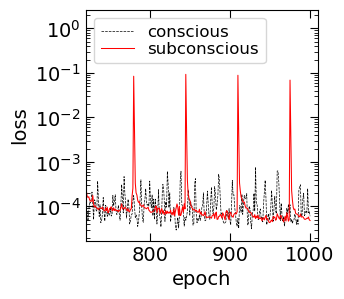

In [11]:
d_ev = params_train['dream_schedule']['dream_every']
plt.figure(figsize=(3,3))
plt.xlim(Max_Epoch-280,Max_Epoch+10)
plt.yscale('log')
# plt.xscale('log')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(net.epochs,net.training_loss,'k--',lw=0.5,label='conscious')
plt.plot(net_subc.epochs,net_subc.training_loss,'r-',markersize=1,lw=0.75,label='subconscious')
# for n in range(1,200):
#     plt.axvline(d_ev*n,c='r',lw=1,ls=':')
plt.legend(loc='upper left')
plt.show()

#### Ensembled, conscious

File_Stem: subconscious/gf1d_deep_stdY_ens
Feed-forward neural network setup...
... found data set of dimension 3 with targets of dimension 1
... found 2500 samples
... fraction 0.800 (2000 samples) will be used for training
... will use residual percentiles for hyperparameter comparison
... setup complete
NetworkEnsembleObject initialized
... ... initializing dict self.ensemble
... ... updating ensemble
... ... checking ensemble consistency
... ... defining ensemble weights
... ensemble loaded and checked
Loaded ensembled network
Best test stats:
... subconscious/gf1d_deep_stdY_ens/ensemble/net_r0: 1.990e-02
{'data_dim': 3, 'loss_type': 'square', 'adam': True, 'seed': None, 'standardize_X': False, 'standardize_Y': True, 'file_stem': 'subconscious/gf1d_deep_stdY_ens/ensemble/net_r0', 'verbose': False, 'logfile': None, 'neg_labels': True, 'L': 16, 'wt_decay': 0.0, 'n_layer': [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 1], 'reg_fun': 'none', 'atypes': ['relu', 'relu', 'r

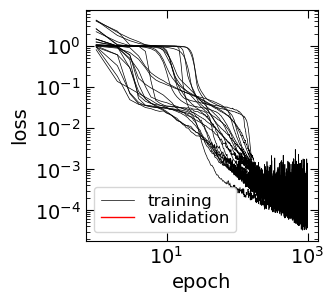

0 min 1.34 seconds



In [12]:
Build = False

Example_Stem_Single = Example_Root + '_ens'

File_Stem = 'subconscious/' + Example_Stem_Single
print('File_Stem:',File_Stem)

Train_Frac = 0.8                               # fraction of input samples to use for training+validation. 
                                               # remaining used for arch and hyperparam comparisons.
Check_After = Max_Epoch                        # epoch after which to activate validation (early stopping) checks
Val_Frac = 0.2 if Check_After < Max_Epoch else 0.0
                                               # fraction of Train_Frac to use for validation, i.e. early stopping criterion.
Arch_Type = 'emulator:'+Depth_Str_Root         # None or one of ['emulator:deep','emulator:shallow','no_reg','autoenc']. 
Min_Layer = 2 if Shallow else 4                # minimum number of layers (x4 for deep)
Max_Layer = 4 if Shallow else 6                # maximum number of layers (x4 for deep)
Max_Ex = [7,17]                                # int or list of ints. number of nodes in excess of input dimension 
                                               # (currently forced to be constant across layers)
HTypes = ['tanh'] if Shallow else ['relu']     # None or subset of ['tanh','relu','lrelu','requ','splus'] 
LRates = [3e-4,1e-3]                           # None or list of floats: learning rates
Wt_Decays = [0.0,0.1]                          # non-empty list of floats: weight decay values
N_Iter = 20                                    # number of iterations for each choice of arch and hyperparams
Loss_Type = 'square'                           # one of ['square','hinge','nll','nllm']
Seed = None                                    # None or int, random number seed.
Test_Type = 'perc'                             # one of 'perc' (residual percentiles) or 'mse' (mean squared error). 
                                               # relevant for regression (square/hinge loss).
Parallel = True                                # train networks in parallel
NProc = 10                                     # number of concurrent processes (only relevant if Parallel = True)
Dream_Schedules = [None]                       # dreaming schedules

start_time = time()
bnn = BuildNN(X_train,Y_train,train_frac=Train_Frac,arch_type=Arch_Type,standardize_X=Standardize_X,standardize_Y=Standardize_Y,
              max_ex=Max_Ex,min_layer=Min_Layer,max_layer=Max_Layer,dream_schedules=Dream_Schedules,
              val_frac=Val_Frac,n_iter=N_Iter,wt_decays=Wt_Decays,lrates=LRates,htypes=HTypes,check_after=Check_After,
              parallel=Parallel,nproc=NProc,loss_type=Loss_Type,test_type=Test_Type,seed=Seed,file_stem=File_Stem,ensemble=True)

if Build:
    neo = bnn.trainNN(max_epoch=Max_Epoch)
else:
    neo = bnn.load() # network ensemble object
    print('Loaded ensembled network')

print('Best test stats:')
for key in neo.keys:
    print('... '+key+': {0:.3e}'.format(neo.ensemble[key]['teststat']))
    print(neo.ensemble[key]['net'].params)
    print(neo.ensemble[key]['ptrain'])

print('No. of free params optimized:')
ens_avg_Nwts = []
for key in neo.keys:
    nwts_this = neo.ensemble[key]['net'].calc_N_freeparams()
    print('... '+key+': {0:d}'.format(nwts_this))
    ens_avg_Nwts.append(nwts_this)
ens_avg_Nwts = np.mean(ens_avg_Nwts)
print('... average: {0:.1f}'.format(ens_avg_Nwts))

plt.figure(figsize=(3,3))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('epoch')
plt.ylabel('loss')
for n in range(len(neo.keys)):
    key = neo.keys[n]
    net = neo.ensemble[key]['net']
    plt.plot(net.epochs,net.training_loss,'k-',lw=0.5,label='training' if n==0 else None)
    plt.plot(net.epochs,net.val_loss,'r-',lw=1,label='validation' if n==0 else None)
plt.legend()
plt.show()

residual_ens = np.squeeze(neo.predict(X_test)/(Y_test + 1e-15) - 1)

ut.time_this(start_time)

#### Ensembled, subconscious

File_Stem: subconscious/gf1d_deep_stdY_subc_ens
Feed-forward neural network setup...
... found data set of dimension 3 with targets of dimension 1
... found 2500 samples
... fraction 0.800 (2000 samples) will be used for training
... will use residual percentiles for hyperparameter comparison
... setup complete
NetworkEnsembleObject initialized
... ... initializing dict self.ensemble
... ... updating ensemble
... ... checking ensemble consistency
... ... defining ensemble weights
... ensemble loaded and checked
Loaded ensembled network
Best test stats:
... subconscious/gf1d_deep_stdY_subc_ens/ensemble/net_r0: 3.127e-02
{'data_dim': 3, 'loss_type': 'square', 'adam': True, 'seed': None, 'standardize_X': False, 'standardize_Y': True, 'file_stem': 'subconscious/gf1d_deep_stdY_subc_ens/ensemble/net_r0', 'verbose': False, 'logfile': None, 'neg_labels': True, 'L': 24, 'wt_decay': 0.0, 'n_layer': [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 1], '

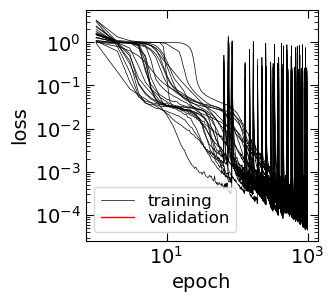

0 min 0.99 seconds



In [13]:
Build = False

Example_Stem_Single = Example_Root + '_subc_ens'

File_Stem = 'subconscious/' + Example_Stem_Single
print('File_Stem:',File_Stem)

Train_Frac = 0.8                               # fraction of input samples to use for training+validation. 
                                               # remaining used for arch and hyperparam comparisons.
Check_After = Max_Epoch                        # epoch after which to activate validation (early stopping) checks
Val_Frac = 0.2 if Check_After < Max_Epoch else 0.0
                                               # fraction of Train_Frac to use for validation, i.e. early stopping criterion.
Arch_Type = 'emulator:'+Depth_Str_Root         # None or one of ['emulator:deep','emulator:shallow','no_reg','autoenc']. 
Min_Layer = 2 if Shallow else 4                # minimum number of layers (x4 for deep)
Max_Layer = 4 if Shallow else 6                # maximum number of layers (x4 for deep)
Max_Ex = [7] if Shallow else [17]              # int or list of ints. number of nodes in excess of input dimension 
                                               # (currently forced to be constant across layers)
HTypes = ['tanh'] if Shallow else ['relu']     # None or subset of ['tanh','relu','lrelu','requ','splus'] 
LRates = [3e-4,1e-3]                           # None or list of floats: learning rates
Wt_Decays = [0.0]                              # non-empty list of floats: weight decay values
N_Iter = 3                                     # number of iterations for each choice of arch and hyperparams
Loss_Type = 'square'                           # one of ['square','hinge','nll','nllm']
Seed = None                                    # None or int, random number seed.
Test_Type = 'perc'                             # one of 'perc' (residual percentiles) or 'mse' (mean squared error). 
                                               # relevant for regression (square/hinge loss).
Parallel = True                                # train networks in parallel
NProc = 10                                     # number of concurrent processes (only relevant if Parallel = True)
Dream_Schedules = []                           # dreaming schedules
dEvs = [65,75,85]
cXs = [0.7,0.8,0.9]
cYs = [0.025,0.05,0.1]
for dEv in dEvs:
    for cX in cXs:
        for cY in cYs:
            ds = {'dream_every':dEv,
                  'corrupt_X':cX,
                  'corrupt_Y':cY}
            Dream_Schedules.append(ds)

start_time = time()
bnn = BuildNN(X_train,Y_train,train_frac=Train_Frac,arch_type=Arch_Type,standardize_X=Standardize_X,standardize_Y=Standardize_Y,
              max_ex=Max_Ex,min_layer=Min_Layer,max_layer=Max_Layer,dream_schedules=Dream_Schedules,
              val_frac=Val_Frac,n_iter=N_Iter,wt_decays=Wt_Decays,lrates=LRates,htypes=HTypes,check_after=Check_After,
              parallel=Parallel,nproc=NProc,loss_type=Loss_Type,test_type=Test_Type,seed=Seed,file_stem=File_Stem,ensemble=True)

if Build:
    neo_subc = bnn.trainNN(max_epoch=Max_Epoch)
else:
    neo_subc = bnn.load() # network ensemble object
    print('Loaded ensembled network')

print('Best test stats:')
for key in neo_subc.keys:
    print('... '+key+': {0:.3e}'.format(neo_subc.ensemble[key]['teststat']))
    print(neo_subc.ensemble[key]['net'].params)
    print(neo_subc.ensemble[key]['ptrain'])

print('No. of free params optimized:')
ens_subc_avg_Nwts = []
for key in neo_subc.keys:
    nwts_this = neo_subc.ensemble[key]['net'].calc_N_freeparams()
    print('... '+key+': {0:d}'.format(nwts_this))
    ens_subc_avg_Nwts.append(nwts_this)
ens_subc_avg_Nwts = np.mean(ens_avg_Nwts)
print('... average: {0:.1f}'.format(ens_subc_avg_Nwts))

plt.figure(figsize=(3,3))
plt.yscale('log')
plt.xscale('log')
plt.xlabel('epoch')
plt.ylabel('loss')
for n in range(len(neo_subc.keys)):
    key = neo_subc.keys[n]
    net_this = neo_subc.ensemble[key]['net']
    plt.plot(net_this.epochs,net_this.training_loss,'k-',lw=0.5,label='training' if n==0 else None)
    plt.plot(net_this.epochs,net_this.val_loss,'r-',lw=1,label='validation' if n==0 else None)
    net_this = None
plt.legend()
plt.show()

residual_subc_ens = np.squeeze(neo_subc.predict(X_test)/(Y_test + 1e-15) - 1)

ut.time_this(start_time)

### Plot

Writing to file: subconscious/plots/gf1d_deep_stdY.png
median +- 1sigma
...   single (   conscious): -0.1048 + 0.5965 - 0.8290 %
...   single (subconscious): -0.1364 + 0.6783 - 0.7095 %
... ensemble (   conscious): -0.1036 + 0.3434 - 0.2605 %
... ensemble (subconscious): -0.0332 + 0.4198 - 0.6779 %


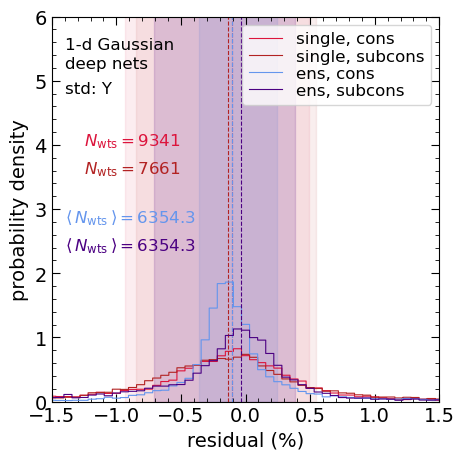

In [14]:
res_16pc = np.percentile(residual,16)*100
res_med  = np.median(residual)*100
res_84pc = np.percentile(residual,84)*100

res_subc_16pc = np.percentile(residual_subc,16)*100
res_subc_med  = np.median(residual_subc)*100
res_subc_84pc = np.percentile(residual_subc,84)*100

res_ens_16pc = np.percentile(residual_ens,16)*100
res_ens_med  = np.median(residual_ens)*100
res_ens_84pc = np.percentile(residual_ens,84)*100

res_subc_ens_16pc = np.percentile(residual_subc_ens,16)*100
res_subc_ens_med  = np.median(residual_subc_ens)*100
res_subc_ens_84pc = np.percentile(residual_subc_ens,84)*100

bins = np.linspace(-25,25,801)
bin_mid = 0.5*(bins[1:]+bins[:-1])

hist,bins = np.histogram(residual*100,bins=bins,density=False)
hist = hist/residual.size/(bins[1]-bins[0])

hist_ens,bins = np.histogram(residual_ens*100,bins=bins,density=False)
hist_ens = hist_ens/residual_ens.size/(bins[1]-bins[0])

hist_subc,bins = np.histogram(residual_subc*100,bins=bins,density=False)
hist_subc = hist_subc/residual_subc.size/(bins[1]-bins[0])

hist_subc_ens,bins = np.histogram(residual_subc_ens*100,bins=bins,density=False)
hist_subc_ens = hist_subc_ens/residual_subc_ens.size/(bins[1]-bins[0])

XLoc  = 1.5
dXLoc = 0.1
cols = ['crimson','cornflowerblue','firebrick','indigo']
plt.figure(figsize=(5,5))
plt.xlim(-XLoc,XLoc)
plt.ylim(0,6)
plt.xlabel('residual (%)')
plt.ylabel('probability density')

plt.plot(bin_mid,hist,'-',c=cols[0],lw=0.8,drawstyle='steps',label='single, cons')
plt.axvline(res_med,c=cols[0],ls='--',lw=0.8)
plt.fill_betweenx(np.linspace(0,7,10),res_16pc,res_84pc,color=cols[0],alpha=0.075)

plt.plot(bin_mid,hist_subc,'-',c=cols[2],lw=0.8,drawstyle='steps',label='single, subcons')
plt.axvline(res_subc_med,c=cols[2],ls='--',lw=0.8)
plt.fill_betweenx(np.linspace(0,7,10),res_subc_16pc,res_subc_84pc,color=cols[2],alpha=0.075)

plt.plot(bin_mid,hist_ens,'-',c=cols[1],lw=0.8,drawstyle='steps',label='ens, cons')
plt.axvline(res_ens_med,c=cols[1],ls='--',lw=0.8)
plt.fill_betweenx(np.linspace(0,7,10),res_ens_16pc,res_ens_84pc,color=cols[1],alpha=0.15)

plt.plot(bin_mid,hist_subc_ens,'-',c=cols[3],lw=0.8,drawstyle='steps',label='ens, subcons')
plt.axvline(res_subc_ens_med,c=cols[3],ls='--',lw=0.8)
plt.fill_betweenx(np.linspace(0,7,10),res_subc_ens_16pc,res_subc_ens_84pc,color=cols[3],alpha=0.15)

plt.minorticks_on()
plt.legend(loc='upper right')
plt.text(-XLoc+dXLoc,5.5,Example_Text,fontsize=FS3)
plt.text(-XLoc+dXLoc,5.2,Depth_Str_Root+' nets',fontsize=FS3)
plt.text(-XLoc+dXLoc,4.8,Std_Text,fontsize=FS3)
plt.text(-XLoc+dXLoc*2.5,4,'$N_{{\\rm wts}} = {0:d}$'.format(net.calc_N_freeparams()),fontsize=FS3,c=cols[0])
plt.text(-XLoc+dXLoc*2.5,3.55,'$N_{{\\rm wts}} = {0:d}$'.format(net_subc.calc_N_freeparams()),fontsize=FS3,c=cols[2])
plt.text(-XLoc+dXLoc,2.8,'$\\langle \\, N_{{\\rm wts}} \\, \\rangle = {0:.1f}$'.format(ens_avg_Nwts),fontsize=FS3,c=cols[1])
plt.text(-XLoc+dXLoc,2.35,'$\\langle \\, N_{{\\rm wts}} \\, \\rangle = {0:.1f}$'.format(ens_subc_avg_Nwts),fontsize=FS3,c=cols[3])
if Save_Fig:
    outfile = Plot_Stem + '/' + Example_Root + '.png'
    print('Writing to file: '+outfile)
    plt.savefig(outfile,bbox_inches='tight')
else:
    plt.show()

print('median +- 1sigma')
print('...   single (   conscious): {0:+.4f} + {1:.4f} - {2:.4f} %'.format(res_med,
                                                                          res_84pc-res_med,
                                                                          res_med-res_16pc))
print('...   single (subconscious): {0:+.4f} + {1:.4f} - {2:.4f} %'.format(res_subc_med,
                                                                          res_subc_84pc-res_subc_med,
                                                                          res_subc_med-res_subc_16pc))
print('... ensemble (   conscious): {0:+.4f} + {1:.4f} - {2:.4f} %'.format(res_ens_med,
                                                                          res_ens_84pc-res_ens_med,
                                                                          res_ens_med-res_ens_16pc))
print('... ensemble (subconscious): {0:+.4f} + {1:.4f} - {2:.4f} %'.format(res_subc_ens_med,
                                                                          res_subc_ens_84pc-res_subc_ens_med,
                                                                          res_subc_ens_med-res_subc_ens_16pc))